### Курсовой проект

Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

По шагам:
0. выбрать себе датасет (который интересен или нравится больше всего), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
1. установить удобную для себя среду разработки (pycharm прекрасен - https://www.jetbrains.com/pycharm/)
2. для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта конечно же при этом)
3. завести себе аккаунт на github (если его еще нет). У самого github есть такой "hello world" по работе с ним - https://guides.github.com/activities/hello-world/
4. итоговый проект должен содержать: 1) каталог app/models/ (здесь модель-пайплайн предобученная) 2) файл app/run_server.py (здесь основной код flask-приложения) 3) requirements.txt (список пакетов, которые у вас используются в проекте - в корне проекта) 4) README.md (здесь какое-то описание, что вы делаете, что за данные, как запускать и т.д) 5) Dockerfile 6) docker-entrypoint.sh
5. (<b>Опционально</b>): front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

Полезные ссылки:
1. датасеты (для полета мысли): https://www.kaggle.com/datasets
2. конкурс Сбербанка по недвижимости (можно этот набор данных также взять и обучить модель предсказывать стоимость жилья - неплохой такой сервис может получиться) - https://www.kaggle.com/c/sberbank-russian-housing-market/data Там же и ноутбуки с разными подходами есть.
3. минималистичный пример связки keras/flask https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html для определения класса картинки
4. неплохой такой пример (помимо того, что разобрали на занятии) связки docker/flask - https://cloud.croc.ru/blog/byt-v-teme/flask-prilozheniya-v-docker/
5. https://www.digitalocean.com/community/tutorials/how-to-build-and-deploy-a-flask-application-using-docker-on-ubuntu-18-04

In [1]:
import pandas as pd
import numpy as np
import dill
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

Датасет на предсказание оттока в телекоммуникационной компании, бинарная классификация, цевая переменная - churn

Признаки:

AccountWeeks - number of weeks customer has had active account

ContractRenewal - 1 if customer recently renewed contract, 0 if not

DataPlan - 1 if customer has data plan, 0 if not

DataUsage - gigabytes of monthly data usage

CustServCalls - number of calls into customer service

DayMins - average daytime minutes per month

DayCalls - average number of daytime calls

MonthlyCharge - average monthly bill

OverageFee - largest overage fee in last 12 months

RoamMins - average number of roaming minutes

In [3]:
df = pd.read_csv("telecom_churn.csv")
df.head(3)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2


In [4]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Churn'],axis=1), df['Churn'], random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2)

#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns ]   
class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p = 2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key+str(i) for i in range(1,self.p) ]
        self.columns = B+['log']
        print(B)
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2,self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])
        Xp = np.hstack([Xp,np.log(X.values.reshape(-1,1) +1 ).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index,columns =[self.columns] )
        return B[self.columns ]     

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1874 entries, 2675 to 2719
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AccountWeeks     1874 non-null   int64  
 1   ContractRenewal  1874 non-null   int64  
 2   DataPlan         1874 non-null   int64  
 3   DataUsage        1874 non-null   float64
 4   CustServCalls    1874 non-null   int64  
 5   DayMins          1874 non-null   float64
 6   DayCalls         1874 non-null   int64  
 7   MonthlyCharge    1874 non-null   float64
 8   OverageFee       1874 non-null   float64
 9   RoamMins         1874 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 161.0 KB


In [8]:
X_train.describe()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000
mean,100.111526,0.900747,0.277481,0.809082,1.545358,181.189701,100.721985,56.428602,10.028052,10.144184
std,39.655509,0.299081,0.447876,1.262130,1.317395,54.342022,19.397274,16.237495,2.505962,2.763601
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.700000,2.130000,0.000000
25%,73.000000,1.000000,0.000000,0.000000,1.000000,144.600000,88.000000,45.000000,8.300000,8.400000
50%,99.000000,1.000000,0.000000,0.000000,1.000000,181.250000,101.000000,53.700000,10.050000,10.200000
75%,127.000000,1.000000,1.000000,1.752500,2.000000,217.575000,114.000000,66.000000,11.677500,12.000000
max,225.000000,1.000000,1.000000,5.400000,9.000000,350.800000,160.000000,110.000000,18.190000,20.000000


In [9]:
X_train.head(3)

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
2675,60,1,0,0.0,0,207.8,109,46.0,6.18,5.7
2151,72,1,0,0.0,2,137.6,106,36.0,7.18,9.6
1033,70,1,0,0.0,2,198.6,111,52.0,10.70,10.6


In [10]:
X_train.columns

Index(['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins'],
      dtype='object')

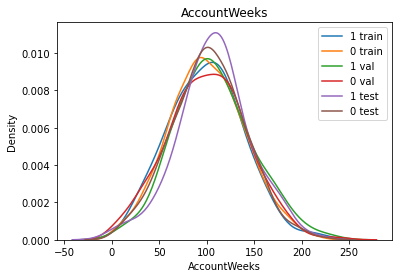

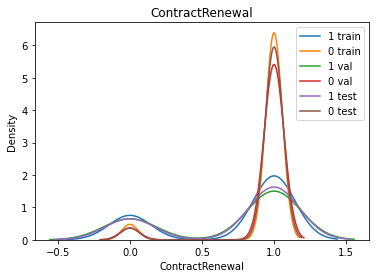

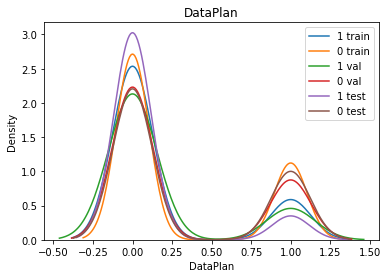

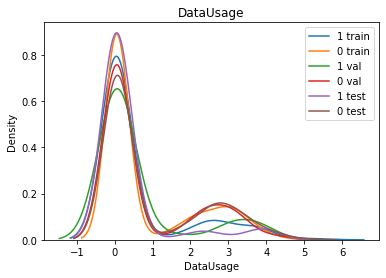

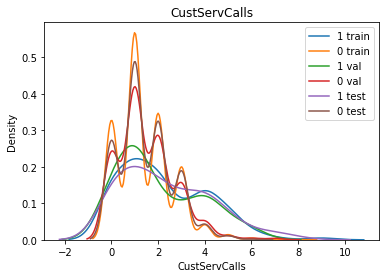

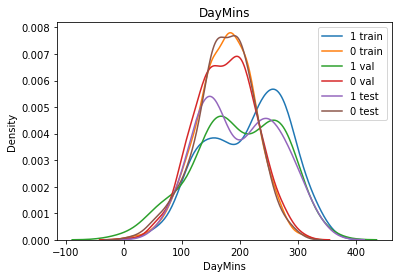

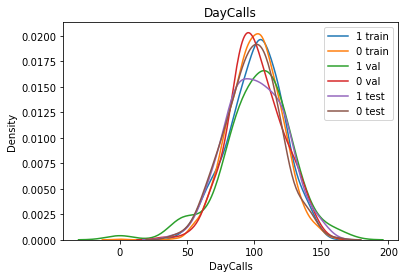

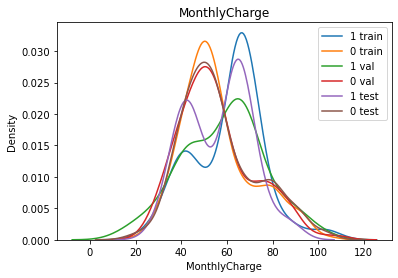

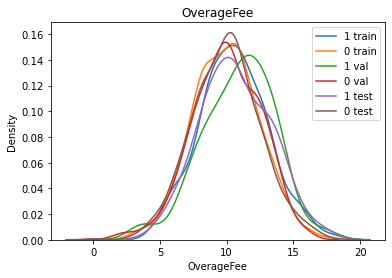

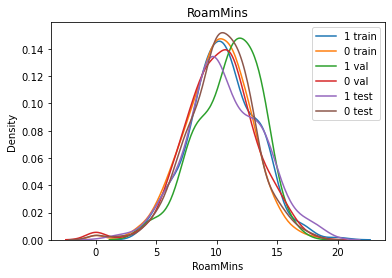

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:,:].select_dtypes(include=numerics).columns:
        sns.kdeplot(X_train.loc[y_train == 1,i], label = '1 train')
        sns.kdeplot(X_train.loc[y_train == 0,i], label ='0 train')
        
        sns.kdeplot(X_val.loc[y_val == 1,i], label = '1 val')
        sns.kdeplot(X_val.loc[y_val == 0,i], label =  '0 val')
        
        sns.kdeplot(X_test.loc[y_test == 1,i], label = '1 test')
        sns.kdeplot(X_test.loc[y_test == 0,i], label =  '0 test')
        plt.title(i)
        plt.legend()
        plt.show()        

In [12]:
continuous_columns = ['AccountWeeks', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins']
categorical_bin_columns = ['ContractRenewal', 'DataPlan']

In [13]:
#проверка пайплайн

NumericPower
CustServCalls = Pipeline([
                ('selector', FeatureSelector(column='CustServCalls')),
                ('ohe', NumericPower(key='CustServCalls',p=3))
            ])
CustServCalls.fit(X_train)
print(CustServCalls.transform(X_test).head(3))

['CustServCalls1', 'CustServCalls2', 'CustServCalls3']
     CustServCalls1 CustServCalls2 CustServCalls3       log
2313            3.0            9.0           27.0  1.386294
2036            3.0            9.0           27.0  1.386294
920             1.0            1.0            1.0  0.693147


In [14]:
OHEEncoderBin

gender = Pipeline([
                ('selector', FeatureSelector(column='ContractRenewal')),
                ('ohe', OHEEncoder(key='ContractRenewal'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(13)

,ContractRenewal_0,ContractRenewal_1
2313,0,1
2036,0,1
920,0,1
2621,0,1
529,1,0
527,0,1
2176,0,1
1945,0,1
110,0,1
1879,0,1


In [15]:
final_transformers = list()


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                
                ('pow_2', NumericPower(key = cont_col, p = 3)),
                ('Scale', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

for cat_col in categorical_bin_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


In [16]:
final_transformers

[('AccountWeeks',
  Pipeline(steps=[('selector', NumberSelector(key='AccountWeeks')),
                  ('pow_2', NumericPower(key='AccountWeeks', p=4)),
                  ('Scale', StandardScaler())])),
 ('DataUsage',
  Pipeline(steps=[('selector', NumberSelector(key='DataUsage')),
                  ('pow_2', NumericPower(key='DataUsage', p=4)),
                  ('Scale', StandardScaler())])),
 ('CustServCalls',
  Pipeline(steps=[('selector', NumberSelector(key='CustServCalls')),
                  ('pow_2', NumericPower(key='CustServCalls', p=4)),
                  ('Scale', StandardScaler())])),
 ('DayMins',
  Pipeline(steps=[('selector', NumberSelector(key='DayMins')),
                  ('pow_2', NumericPower(key='DayMins', p=4)),
                  ('Scale', StandardScaler())])),
 ('DayCalls',
  Pipeline(steps=[('selector', NumberSelector(key='DayCalls')),
                  ('pow_2', NumericPower(key='DayCalls', p=4)),
                  ('Scale', StandardScaler())])),
 ('MonthlyCha

In [17]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

VV = feature_processing.fit_transform(X_train) 
VV

['AccountWeeks1', 'AccountWeeks2', 'AccountWeeks3']
['DataUsage1', 'DataUsage2', 'DataUsage3']
['CustServCalls1', 'CustServCalls2', 'CustServCalls3']
['DayMins1', 'DayMins2', 'DayMins3']
['DayCalls1', 'DayCalls2', 'DayCalls3']
['MonthlyCharge1', 'MonthlyCharge2', 'MonthlyCharge3']
['OverageFee1', 'OverageFee2', 'OverageFee3']
['RoamMins1', 'RoamMins2', 'RoamMins3']


array([[-1.01176946, -0.95190675, -0.80302127, ...,  1.        ,
         1.        ,  0.        ],
       [-0.70908256, -0.76328864, -0.70335078, ...,  1.        ,
         1.        ,  0.        ],
       [-0.75953038, -0.79710653, -0.72252325, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.88564992, -0.87748357, -0.76586225, ...,  1.        ,
         1.        ,  0.        ],
       [-1.08744118, -0.9937028 , -0.82254807, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.47644113,  0.30566637,  0.12819444, ...,  1.        ,
         0.        ,  1.        ]])

In [18]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [19]:
#обучим пайплайн
pipeline.fit(X_train, y_train)

['AccountWeeks1', 'AccountWeeks2', 'AccountWeeks3']
['DataUsage1', 'DataUsage2', 'DataUsage3']
['CustServCalls1', 'CustServCalls2', 'CustServCalls3']
['DayMins1', 'DayMins2', 'DayMins3']
['DayCalls1', 'DayCalls2', 'DayCalls3']
['MonthlyCharge1', 'MonthlyCharge2', 'MonthlyCharge3']
['OverageFee1', 'OverageFee2', 'OverageFee3']
['RoamMins1', 'RoamMins2', 'RoamMins3']


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('AccountWeeks',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='AccountWeeks')),
                                                                 ('pow_2',
                                                                  NumericPower(key='AccountWeeks',
                                                                               p=4)),
                                                                 ('Scale',
                                                                  StandardScaler())])),
                                                ('DataUsage',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='DataUsage')),
                                                              

In [20]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_val)[:, 1]
preds[:10]

array([0.95, 0.  , 0.09, 0.01, 0.02, 0.03, 0.04, 0.03, 0.07, 0.1 ])

In [21]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.430000, F-Score=0.711, Precision=0.762, Recall=0.667


In [22]:
# сохраним модель
with open("randomforest_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)